*Reverse* direction&mdash;making inferences about unseen parts of our model based on observed information. 

In probabilistic modeling, this is accomplished via *conditioning* models on particular outcomes of random variables.

The rest of the course will be devoted to understanding how to efficiently approximate conditional probability distriibutions. 

# 1. Inference

In a Bayesian setting, *inference* refers to hypothetical reason&mdash;implemented using conditional probabilities; asks for likely values of unobserved random variables in the model given particular values of *observed* random variables. 

Let's begin by introducing a few example inference problems to work with.

In [5]:
using Gen
using Distributions
using PyPlot
include("dirichlet.jl");

### Example: Coin Flipping

Here we simply restate our biased coin model in simplified form.


In [6]:
@gen function flip_biased_coin(N)
    θ ~ beta(1,1)
    
    [{:flip => i} ~ bernoulli(θ)  for i in 1:N]
end;

t=Gen.simulate(flip_biased_coin,(5,))
Gen.get_choices(t)

│
├── :θ : 0.23390601247127638
│
└── :flip
    │
    ├── 4 : false
    │
    ├── 2 : false
    │
    ├── 3 : false
    │
    ├── 5 : false
    │
    └── 1 : true


## Inference Problems

In biased coin model, we return the values of the $N$ coin flips. However, $\theta$ is unobserved. Thus a natural inference problem is 

> What is the value of $\theta$ given the $N$ coin tosses that we have seen?

<br>

In Bayesian setting, we always quantify uncertainty over guesses; rather than asking for a specific value of $\theta$, we ask for a distribution over values of $\theta$.

> What is the distribution over $\theta$ given the $N$ coin tosses that we have seen?

Most inference problems will be finding a distribution expressing beliefs or uncertainty in those beliefs. This is a standard statement of *posterior inference*. Typically, we would like to calculate the *posterior distribution* over latent random variables given the observed random variables. 

<br>
<br>

There is a second inference problem in which we could be interested for this model which can be stated as follows:  

> What is the distribution over the next coin flip, given the preceding coin flips. 

This is the statement of another standard inference problem, *posterior predictive inference*. The *posterior predictive distribution* is the distribution over next observations given the preceding observations, averaging over the latent random variables. 



### Example: Mixture Modeling

A standard unsupervised learning problem is *clustering*, refers to the problem of assigning observed data points to one or more categories or groups. A typical application in the cognitive science of language would be the assignment of acoustic segments in speech to particular phonemes. 

In a Bayesian setting, the standard model for unsupervised clustering is the *mixture model*. A mixture model consists of two parts. First, we draw a set of *mixture weights*. This is a probability distribution over particular categories or clusters. Second, each category is associated with a *component distribution* which is a distribution over observations in that category.

The generative process consists of two steps. First, we draw a mixing distribution over components. Second, for each datapoint, we choose a component from the mixing distribution and then use this component distribution to generate the value associated with that datapoint.

<br>


Let's start by creating a way of sampling our mixture weights from a Dirichlet distribution: 

<br>

A dirichlet distribution is a $K$ element generalization of a Beta distribution. In other words, it is a distribution on $K$-sided dice. 

It's density is given by 

$$p\left(\theta_1,\ldots, \theta_{K}; \alpha_1,\ldots, \alpha_K \right) = \frac{\prod_{i=1}^K \Gamma(\alpha_i)}{\Gamma\left(\sum_{i=1}^K \alpha_i\right)} \prod_{i=1}^K \theta_i^{\alpha_i - 1}$$

where $\Gamma(\cdot)$ is Gamma function. In particular $\Gamma(n) = (n-1)!$ when $n$ is an integer.

The Dirichlet distribution is a distribution on *probability vectors*, that is vectors of numbers between $0$ and $1$ which sum to $1$.

In [7]:
dirichlet([1,1,1,1])

4-element Array{Float64,1}:
 0.050035670534955355
 0.23268697374001265
 0.056109563699051686
 0.6611677920259803

The distribution takes as parameter a vector $\vec{\alpha}$ of length $K$ of real numbers greater than $0$ called the vector of *pseudocounts*. These can be thought of as the counts of particular outcomes that occurred hypothetically in the past. 

It's useful to consider the space of probability vectors of length $K$, known as the $(K-1)$-*simplex* $\Theta$.

The only
points in $\mathbb{R}^2$ which are valid probability vectors fall
along a one-dimensional line segment which run between $\langle 0,
1\rangle$ and $\langle 1, 0\rangle$

<br>


What about in $\mathbb{R}^3$? This is a bit more interesting to
visualize and is shown below.

<!-- TODO: remake my own version of these plots. Is there a relevant -->
<!-- javascript library for this? -->
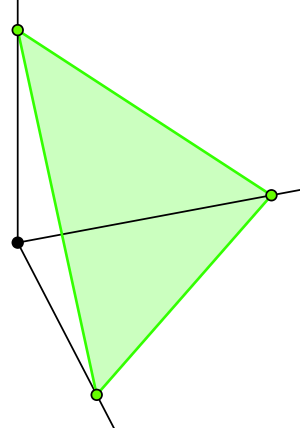
     
In three dimensions, all the valid probability vectors occur in a
two-dimensional triangle anchored at points $\langle 0, 1,
0\rangle$, $\langle 1, 0, 0\rangle$, and $\langle 0, 0,
1\rangle$. In general, all the probability vectors of length $k$
fall into a $(k-1)$-dimensional triangle- or pyramid-shaped subspace
known as the *simplex* over $k-1$ dimensions.


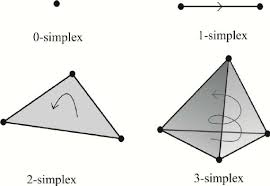

The Dirichlet distribution is a distribution on the simplex whose concentration is controlled by the parameter vector $\alpha$.

In a mixture model, we can use a Dirichlet distribution as a *prior* distribution over mixture components. What kind of distribution should each component be? One popular choice is the *mixture of Gaussians* model, where each component is a Gaussian with its own mean and variance.


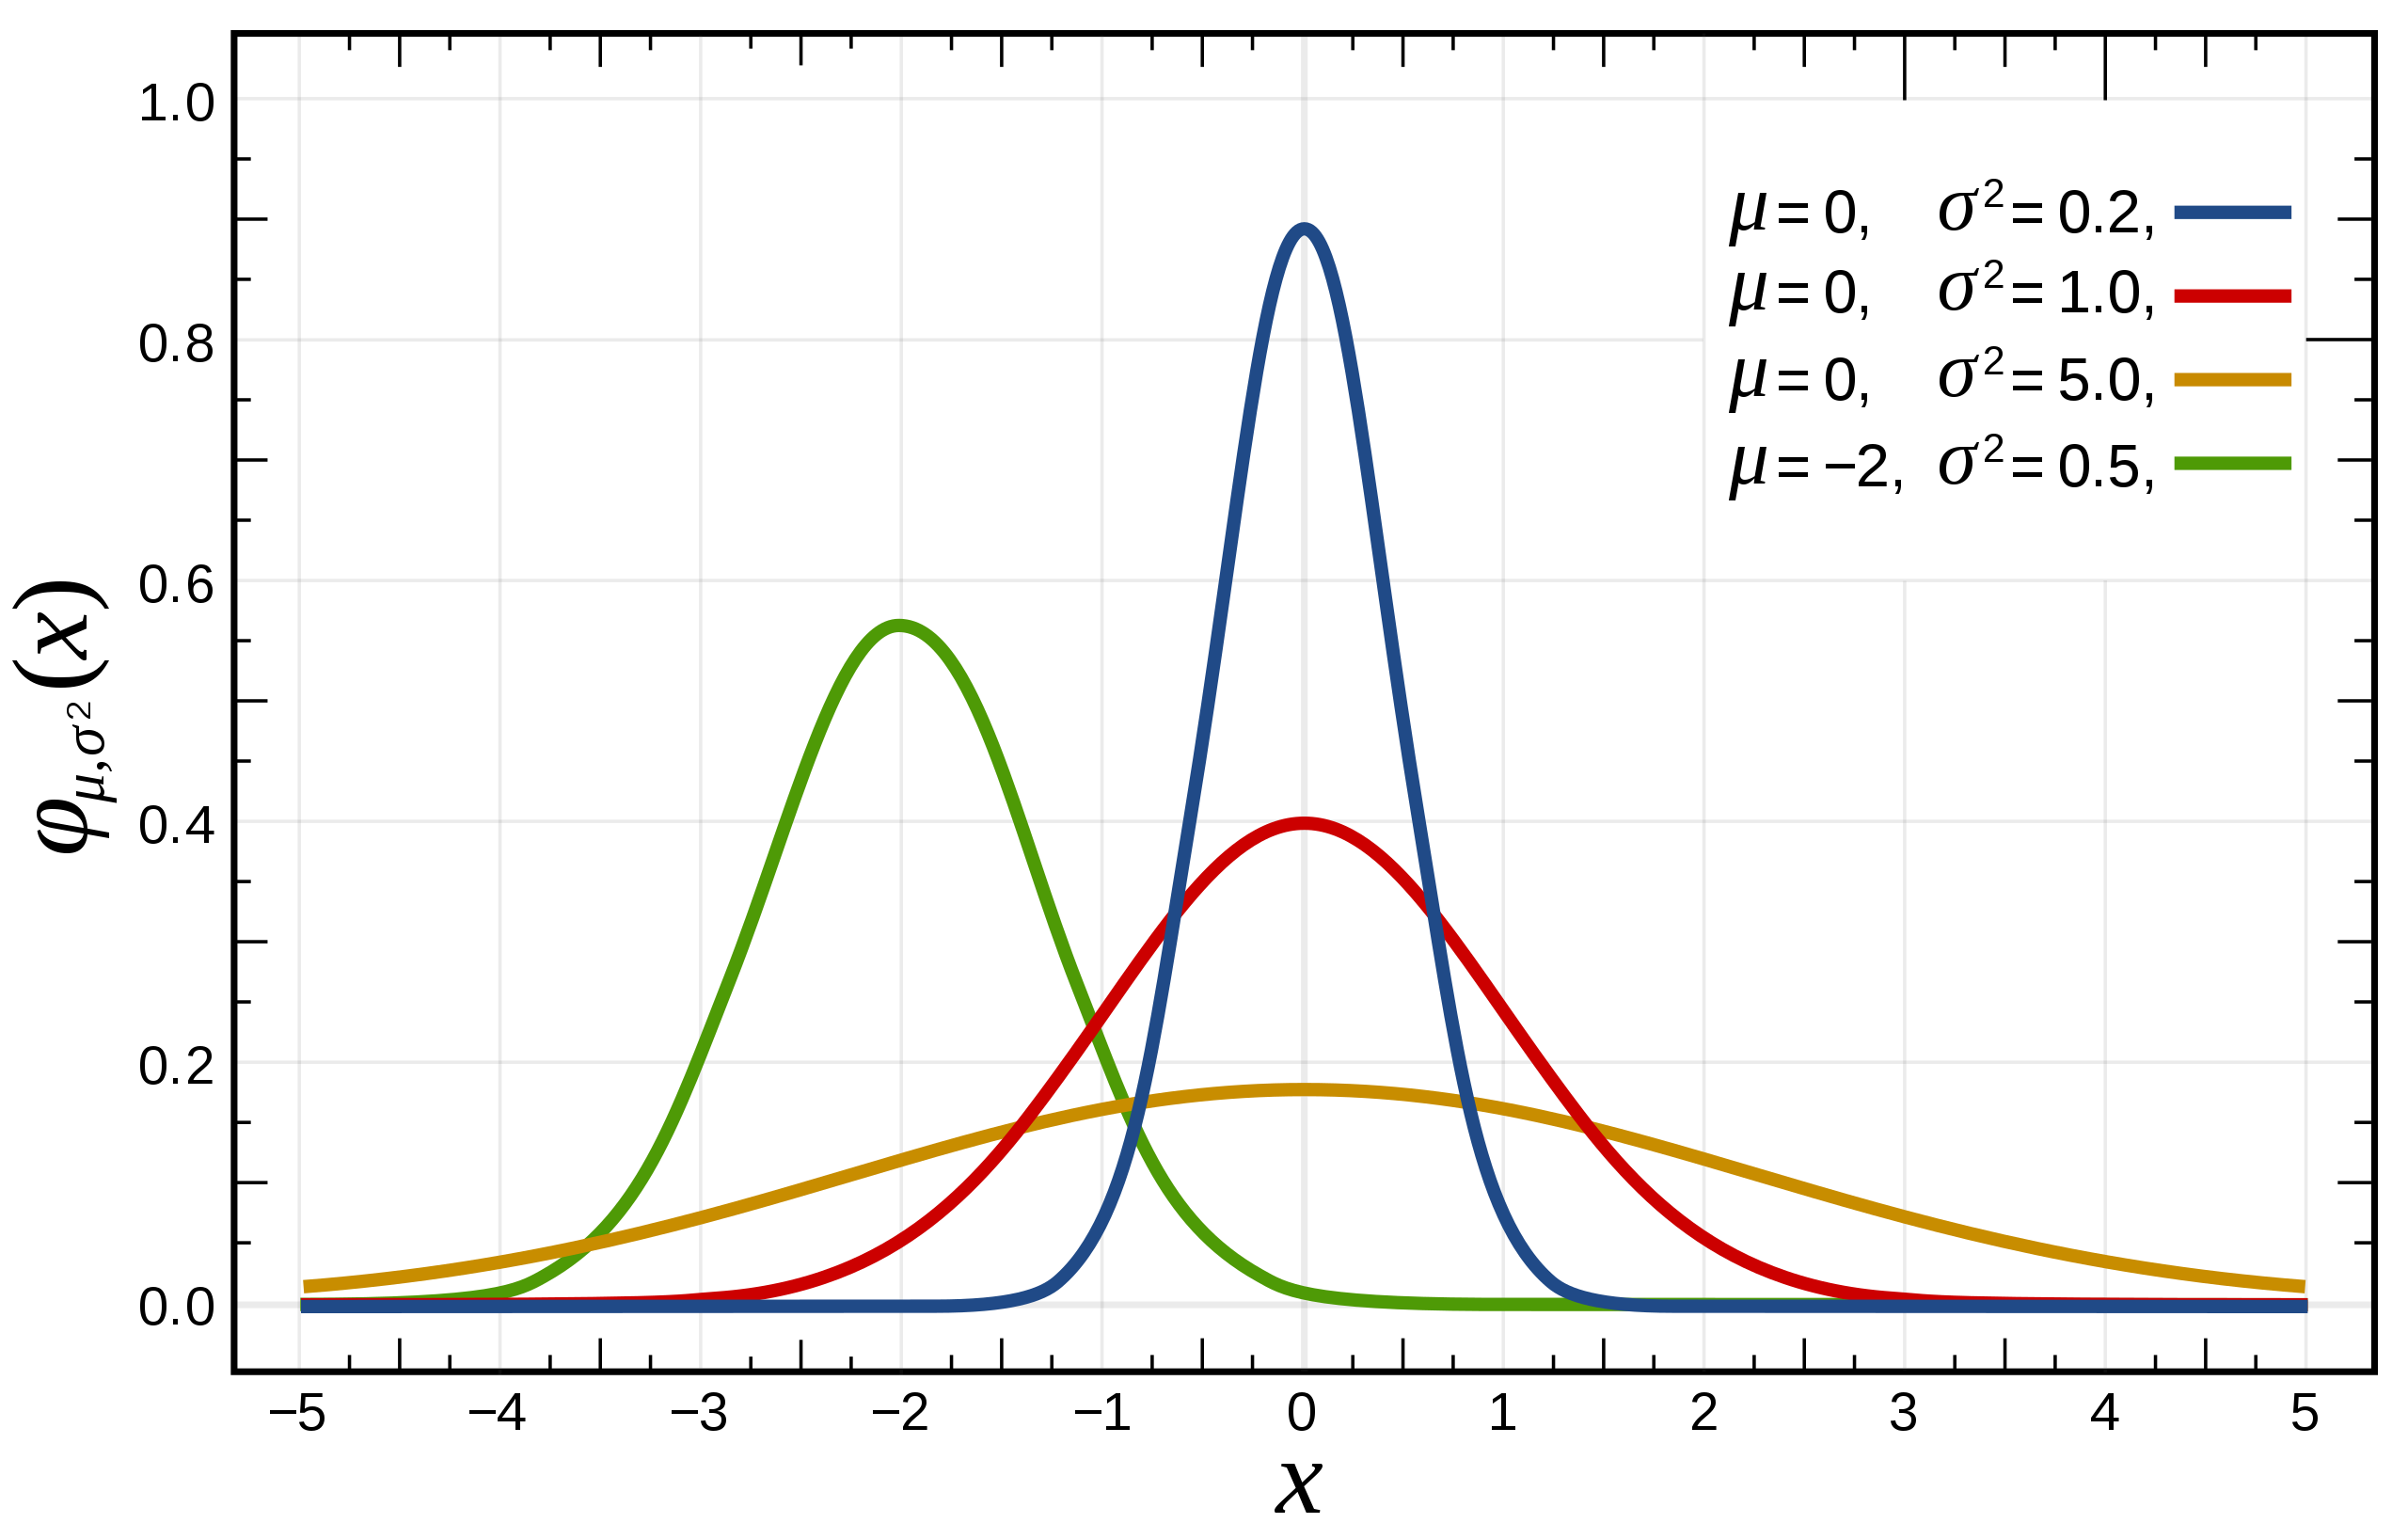


In [8]:
@gen function gmm(K,T)
    # set hyperparameters
    δ = 5 * ones(K)
    ξ = 0.0
    κ = 0.01
    α = 2.0
    β = 10.0
    
    # Draw the mixture weights
    w = {:w} ~ dirichlet(δ)
    
    # Draw the means and variances for each component distribution
    means, vars = zeros(K), zeros(T)
    for j=1:K
        means[j] = ({:μ => j} ~ normal(ξ, 1/κ))
        vars[j] = ({:σ² => j} ~ inv_gamma(α, β))
    end
    
    # Draw the observations
    xs = zeros(T)
    for i=1:T
        z = ({:z => i} ~ categorical(w))
        xs[i] = {:x => i} ~ normal(means[z], vars[z])
    end
    xs
end

t=Gen.simulate(gmm,(3,5))
get_choices(t)

│
├── :w
│   │
│   ├── 2 : 0.27802938830258656
│   │
│   ├── 3 : 0.29084221899097745
│   │
│   └── 1 : 0.4311283927064359
│
├── :μ
│   │
│   ├── 2 : 36.8517803768135
│   │
│   ├── 3 : 142.9880838641949
│   │
│   └── 1 : -100.06146401994731
│
├── :σ²
│   │
│   ├── 2 : 3.948944908203942
│   │
│   ├── 3 : 9.423180554687942
│   │
│   └── 1 : 3.306699389008357
│
├── :z
│   │
│   ├── 4 : 1
│   │
│   ├── 2 : 2
│   │
│   ├── 3 : 3
│   │
│   ├── 5 : 3
│   │
│   └── 1 : 2
│
└── :x
    │
    ├── 4 : -97.9423920406535
    │
    ├── 2 : 33.608504502717736
    │
    ├── 3 : 138.35165155416513
    │
    ├── 5 : 139.91712029374204
    │
    └── 1 : 37.132495006652796


## Mathematical Notation

We can express this model in squiggle notation as follows.

$$\pi \sim \mathrm{Dirichlet}(\delta)$$
$$\{\mu_k\}_{k=1}^K \sim \mathrm{Gaussian}(\xi, 1/\kappa)$$
$$\{\sigma^2_k\}_{k=1}^K \sim \mathrm{InverseGamma}(\alpha, \beta)$$
$$\{z_t\}_{1=1}^T \sim \mathrm{categorical}(\pi)$$
$$\{x_t \mid z_t\}_{k=1}^T \sim \mathrm{Gaussian}(\mu_{z_t}, \sigma^2_{z_t})$$


__Joint probabilty__ of the data and the model:

\begin{align}
&\Pr(\pi, \mu_{1:K}, \sigma^2_{1:K}, z_{1:T},x_{1:T} \mid
    \delta, \xi, \kappa, \alpha, \beta) \\
=&\ 
\Pr(\pi \mid \delta)
\left [ \prod_{k=1}^K 
    \Pr(\mu_k \mid \xi,\kappa )
    \Pr(\sigma^2_k \mid \alpha, \beta ) 
\right ] 
\left[ \prod_{t=1}^T 
    \Pr(z_t | \pi) 
    \Pr(x_t \mid \mu_{z_t}, \sigma^2_{z_t}) 
\right]\\
=&\ 
\mathrm{Dirichlet}(\pi ; \delta)
\left [ \prod_{k=1}^K 
    \mathrm{Gaussian}(\mu_k ; \xi, 1/\kappa)
    \mathrm{InverseGamma}(\sigma^2_k ; \alpha, \beta)
\right ]
\left[ \prod_{t=1}^T 
    \mathrm{categorical}(z_t ; \pi) 
    \mathrm{Gaussian}(x_t ; \mu_{z_t}, \sigma^2_{z_t}) 
\right]\\
=&\ 
\frac{\prod_{j=1}^K\pi_j^{\delta_j-1}}{B(\delta)}
\left [ \prod_{k=1}^K 
    \sqrt{\frac{\kappa}{2\pi}}\exp\left(-\frac12\kappa(\mu_k-\xi)^2\right)\cdot
    \frac{\beta^\alpha}{\Gamma(\alpha)}\sigma_k^{-2(\alpha-1)}\exp\left(-\frac{\beta}{\alpha}\right)
\right ]
\left[ \prod_{t=1}^T 
    \pi_{z_t}\cdot
    \frac{1}{\sigma_{z_t}\sqrt{2\pi}}\exp\left(-\frac12\frac{(x_t-\mu_{z_t})^2}{\sigma^2_{z_t}}\right)
\right]\\
\end{align}

### Graphical model

![gmm.png](figures/gmm.png)

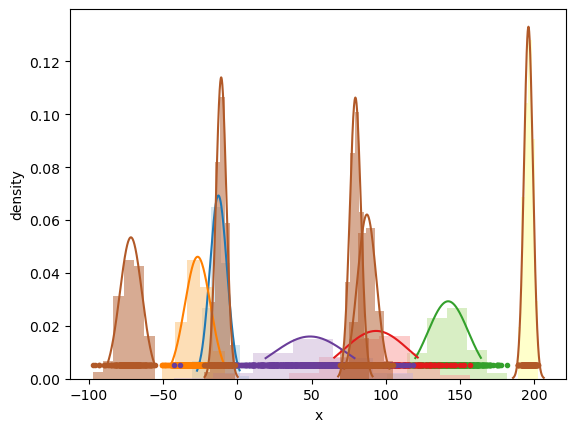

In [9]:
gaussian_pdf(μ, σ²) = x -> exp(Gen.logpdf(normal, x, μ, σ²));
function render_mixture_trace(tr; color_shift=0)
    K, T = get_args(tr)
    cmap = PyPlot.get_cmap("Paired")
    figure()
    
    for j=1:K
        x_js = [tr[:x => i] for i=1:T if tr[:z => i] == j]
        μ, σ² = tr[:μ => j], tr[:σ² => j]
        hist(x_js, bins=6, density=true,color=cmap(2j-2 + 2color_shift), alpha=0.5)
        dom = (μ - 6sqrt(σ²)):1e-1:μ + 6sqrt(σ²)
        plot(dom, gaussian_pdf(μ, σ²).(dom), color=cmap(2j-1+ 2color_shift))
        plot(x_js, 5e-3 .+ zeros(length(x_js)), ".", color=cmap(2j-1 + 2color_shift))
       
        xlabel("x"); ylabel("density");
    end
end;
render_mixture_trace(Gen.simulate(gmm,(10,5000)))

## Inference problems

What inference problems can we imagine for the Gaussian Mixture Model? Typically, we will be given some real-valued observations, that is a vector of $y$s. We wish to infer the posterior distributions over our latent parameters. 

> What is the distribution over mixture weights given the data?

> What is the distribution over each component's mean and variance given the data?

> What is the distribution over the assignment of observations to mixture componets, that is $z$, given the data?



# Example: Regression

The simplest form of a regression model is the linear regression model. 


In [10]:
@gen function line_model(xs::Vector{Float64})
    n = length(xs)

    
    # We begin by sampling a slope and intercept for the line.
    # Before we have seen the data, we don't know the values of
    # these parameters, so we treat them as random choices. The
    # distributions they are drawn from represent our prior beliefs
    # about the parameters: in this case, that neither the slope nor the
    # intercept will be more than a couple points away from 0.
    slope ~ normal(0, 1)
    intercept ~ normal(0, 2)
    
    noise ~ normal(0,2.5)
    
    # Given the slope and intercept, we can sample y coordinates
    # for each of the x coordinates in our input vector.
    ys=zeros(length(xs))
    for (i, x) in enumerate(xs)
       ys[i] = {:y => i} ~ normal(slope * x + intercept, noise^2)
    end
    
    return ys
end;

xs=Array(1:1.0:10)
t=Gen.simulate(line_model, (xs,))
get_choices(t)


│
├── :intercept : 1.1708052780870417
│
├── :slope : 0.25508518198094426
│
├── :noise : 0.9684704166149809
│
└── :y
    │
    ├── 7 : 3.464648418541063
    │
    ├── 4 : 3.7041925940952534
    │
    ├── 9 : 3.6885326326526435
    │
    ├── 10 : 4.46456397783867
    │
    ├── 2 : 0.07022122519418827
    │
    ├── 3 : 0.9554803551858025
    │
    ├── 5 : 1.0617536113123376
    │
    ├── 8 : 2.5532168065956062
    │
    ├── 6 : 1.988983820921634
    │
    └── 1 : 3.288232155222986


In [11]:
function render_regression_trace(trace; show_data=true)
    
    # Pull out xs from the trace
    xs = get_args(trace)[1]
    
    xmin = minimum(xs)
    xmax = maximum(xs)
    if show_data
        ys = [trace[:y=>i] for i=1:length(xs)]
        
        # Plot the data set
        scatter(xs, ys, c="black")
    end
    
    ymin = minimum(ys)
    ymax = maximum(ys)
    
    # Pull out slope and intercept from the trace
    slope = trace[:slope]
    intercept = trace[:intercept]
    
    # Draw the line
    plot([xmin, xmax], slope *  [xmin, xmax] .+ intercept, color="black", alpha=0.5)
    ax = gca()
    ax[:set_xlim]((xmin, xmax))
    ax[:set_ylim]((ymin, ymax))
end;

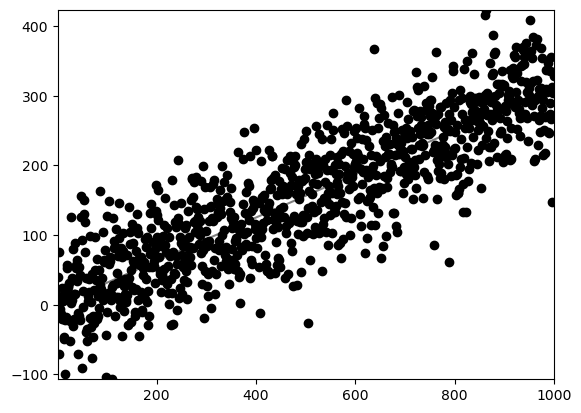

In [12]:
xs=Array(1:1.0:1000)
t=Gen.simulate(line_model, (xs,))
render_regression_trace(t);

## Mathematical Notation

In squiggle notation:

$$m \sim \mathrm{Gaussian}(\mu_m, \sigma^2_m)$$
$$b \sim \mathrm{Gaussian}(\mu_b, \sigma^2_b)$$
$$\epsilon \sim \mathrm{InverseGamma}(\alpha, \beta)$$

$$y_i \sim \mathrm{Gaussian}(m x_i + b, \epsilon)$$

In probability notation:

$$\Pr(\{y_i\}_{i=1}^N,m,b,\epsilon \mid \{x_i\}_{i=1}^N, \{\mu_x,\sigma^2_x\}_{x \in \{m,b,\epsilon\}}) = \Pr(m \mid \mu_m, \sigma^2_m) \Pr(b \mid \mu_b, \sigma^2_b) \Pr(\epsilon \mid \alpha, \beta)\prod_{i=1}^N \Pr(y_i \mid x_i, m, b, \epsilon)$$ 


![regression-bn.jpg](figures/regression-bn.jpg)

## Inference Problems

> What is the distribution of the  slope and intercept of the line given some data?

> What is the noise term of the line given some data?

# Example: Hidden Markov Models

A very common workhorse model in statistics, AI, and NLP and a very well-studied model mathematically is the Hidden Markov Model (HMM). The HMM is a model over sequences such as sentences. Each observed symbol (e.g., a word) is generated conditioned on an underlying state. The states, in turn, are generated conditioned on the last state.



In [9]:
@gen function hmm(T,K,O)
    # set hyperparameters
    δ = ones(K)
    α = ones(K)
    ϵ = ones(O)
    
    # initial distribution over latent states
    π ~ dirichlet(δ) 
    
    transition = zeros(K,K)
    for k in 1:K
        transition[k,:] = {:transition => k} ~ dirichlet(α)
    end
    
    observation = zeros(K,O)
    for k in 1:K
        observation[k,:] = {:observation => k}  ~ dirichlet(ϵ)
    end
        
    xs=zeros(T)
    z = {:z => 1} ~ categorical(π)    
    xs[1] = {:x => 1} ~ categorical(observation[z,:])
    for t in 2:T
        z = ({:z => t} ~ categorical(transition[z,:]))
        xs[t] = {:x => t} ~ categorical(observation[z,:])
    end
    xs
end


t=Gen.simulate(hmm, (4,2,3))
get_choices(t)

LoadError: UndefVarError: dirichlet not defined

## Mathematical Notation

For an HMM of length $T$ timesteps, with discrete states and discrete outputs, at each timestep $t\in {1,\ldots,T}$, we have 
- Latent variable: $Z_t\in\{1,\ldots,K\}$, discrete over $K$ hidden states.
- Observed variable: $X_t\in\{1,\ldots,O\}$, discrete over $O$ possible values (for example, words in the vocabulary).
- Initial probability vector $\pi\in \Delta_{K-1}$
- Transition probabilities can be expressed as a $K\times K$ matrix, $A$, where each row is a probability vector over $z_t$: $A_{[ij]} = p(Z_t = j\mid Z_{t-1}=i)$
- Emission probabilities  are likewise expressed in a matrix, $E$, of dimension $K\times O$, where each row is a probability vector over $x_t$: $E_{[iw]} = p(X_t=w\mid Z_t=i)$

$$\pi \sim \mathrm{Dirichlet}(\delta)$$ 
$$\{A_{[k:]}\}_{k=1}^K \sim \mathrm{Dirichlet}(\alpha)$$
$$\{E_{[k:]}\}_{k=1}^K \sim \mathrm{Dirichlet}(\epsilon)$$
$$Z_1 \sim \mathrm{Categorical}(\pi)$$
$$\{Z_t\}_{t=2}^T \sim \mathrm{Categorical}(A_{[z_{(t-1)}:]})$$
$$X_t \mid Z_t \sim \mathrm{Categorical}(E_{[z_t:]})$$

The joint distribution is factored in terms of of transition and emmission probabilities for each timestep:

\begin{align}
&\Pr(\pi,A,E,x_{1:T},z_{1:t};\delta,\alpha,\epsilon) \\
=&\
\Pr(\pi;\delta)\Pr(z_1 \mid \pi) \Pr(A;\alpha)\Pr(E;\epsilon)
\prod_{t=2}^T 
    \underbrace{\Pr(z_t \mid z_{t-1}, A)}_\text{transition}
\prod_{t=1}^T 
    \underbrace{\Pr(x_t \mid z_t, E)}_{\text{emmission}}\\
=&\ 
\mathrm{Categorical}(z_1;\pi)\cdot\mathrm{Dirichlet}(\pi;\delta)\\
&\cdot
\prod_{k=1}^K \left[
    \mathrm{Dirichlet}(A_{[k:]};\alpha)\cdot
    \mathrm{Dirichlet}(E_{[k:]};\epsilon) \right]\\
&\cdot
\prod_{t=2}^T 
    \mathrm{Categorical}(z_t;A_{[z_{(t-1)}:]})
\prod_{t=1}^T 
    \mathrm{Categorical}(x_t;E_{[z_t:]})\\
=&\ 
\pi_{z_1} \cdot \frac{\prod_k^K\pi^{\delta_k-1}}{B(\delta)}
\cdot
\prod_{k=1}^K \left[
    \frac{\prod_{j=1}^K A_{[k:j]}^{\alpha_j-1}}{B(\alpha)}\cdot
    \frac{\prod_{j=1}^K E_{[k:j]}^{\epsilon_j-1}}{B(\epsilon)}\right]
\cdot
\prod_{t=2}^T 
    A_{[z_{(t-1)}:z_t]}
\prod_{t=1}^T 
    E_{[z_t:x_t]}
\end{align}

Where $\displaystyle B(\alpha_1,\ldots,\alpha_N):= \frac{\prod_{i=1}^N \Gamma(\alpha_i)}{\Gamma\left(\sum_{i=1}^N \alpha_i\right)}$.


### Graphical Model

![hmm.png](figures/hmm.png)

## Inference Problems

> Given a sequence of observations (e.g., words) what is sequence of states that generated those words?

> Given a corpus of observed sequences (e.g., sentences) what are the transition and observation parameters of the model?

# 2. Inference via Conditioning


In examples above, inference problem is finding the *conditional distribution* over unknown random variables given values of known random variables. 

In the simulation unit, we talked about the interpretation of conditional probabilities. 

>  For a conditional distribution, we are  **required** to use the value of the random variable specified in the condition; we absolutely **need** this information to draw our sample.

<br>

For instance, the joint distribution in the biased coin model was given by 

$$\Pr(\theta, \{x_i\}_{i=1}^N \mid \alpha, \beta) = \Pr(\theta \mid \alpha, \beta) \prod_{i=1}^N \Pr(x_i\mid \theta)$$

The posterior inference question is the following conditional distribution:

$$\Pr(\theta \mid \{x_i\}_{i=1}^N, \alpha, \beta )$$

which is not model definition. How do we know how $\theta$ depends on $\{x_i\}_{i=1}^N$? 

For unknown conditional distributions, we must compute their values using the laws of probability theory. 

# 3. Samplers and Scorers

Note there is an important distinction:

For a given probability density $\langle \Omega,p \rangle$,

> A sampler is a function that draws values from $\Omega$ according to $p$. 

> A scorer, by contrast, is a function that takes values from $\Omega$ and returns their density under $p$. That is, the scorer implements the density itself.


# 4. Operations of Probability Theory

To compute posterior distribution $$\Pr(\theta \mid \{x_i\}_{i=1}^N, \alpha, \beta )$$

we always start with a joint distribution over random variables: $$\Pr(\theta \mid \alpha, \beta) \prod_{i=1}^N \Pr(x_i\mid \theta)$$

<br>

Computational probability theory contains two operations we can use: *marginalization* and *conditioning*. Since conditioning is defined in terms of marginalization, we will start with that.

## 4.1 Marginalization

For a given joint distribution, $\Pr(A,B)$, a *marginal distribution* is distribution only contains subset of random variables in the joint, such as $\Pr(A)$ (for some set of random variables $\mathbf{X}=\{X^{(1)}, \dots, X^{(K)}\}$ there are $\mathcal{P}(\mathbf{X})-1$ possible marginal distributions).

How are marginal distributions related to joint distributions? 

<br>

 - First consider the point of view of *scoring* which is how marginalization is typically introduced:

      The definition of marginalization is given by

    $$\Pr(X^{(1)}, \dots, X^{(M)})= \sum_{X^{(M+1)},\dots,X^{(K)}} \Pr(X^{(1)}, \dots, X^{(M)}, X^{(M+1)}, \dots, X^{(K)})$$

      **Thus, marginalization is a way of getting rid of/marginalize away some random variables in a joint distribution, by summing over all of the values of these random variables.**

      Marginal distributions are called as such because if we think about the tabular view of joint distributions, they can be written in the "margins" of the table. 
      
      Returning to our `flip_two` example from the last unit, we marginalize *over* a variable like $X^{(1)}$ or we *marginalize* $X^{(1)}$ *away*. 
      

|    $$X^{(1)}\backslash X^{(2)}$$  |`true`|`false`| $$\Pr(X^{(1)})$$|
|---      |---|---|---|
| `true`  |  $$p(\texttt{true},\texttt{true})$$ |$$p(\texttt{true}, \texttt{false})$$| $$p_{X^{(1)}}(\texttt{true})$$|
| `false` |  $$p(\texttt{false}, \texttt{true})$$ |$$p(\texttt{false},\texttt{false})$$| $$p_{X^{(1)}}(\texttt{false})$$|
| $$\Pr(X^{(2)})$$ |  $$p_{X^{(2)}}(\texttt{true})$$ |$$p_{X^{(2)}}(\texttt{false})$$| |

   

 
    Note that marginalization can be a very expensive operation as it requires to sum over every value of every random variable that we wish to marginalize away. If these random variables have large supports and there are many of them, then we will be marginalizing over a cartesian product which can be extraordinarily large. 

<br>

- What is marginalization from a sampling point of view? 

    If we have a generative function samples from some joint distribution, marginalization corresponds to simply "ignoring," or "not returning" the values of the random variables that have been marginalized away. 
    
    We see here why the sampling perspective may be valuable computationally in some cases: While scoring a marginal probability over a set of random variables can be exponentially costly, sampling from the same marginal is typically quite cheap.  


## Conditioning

For discrete random variables, conditioning is defined as follows:

$$\Pr(X=x | Y=y) = \frac{\Pr(X=x,Y=y)}{\Pr(Y=y)} = \frac{\Pr(X=x,Y=y)}{\sum_{x^{\prime} \in X} \Pr(X=x^{\prime},Y=y)}$$

The expression to the right of the conditioning bar is
called the *conditioner*. We can think of conditioning as a two step process. First, we get the
subset of joint states where the conditioner is true, or we remove all of the states where the conditioner is
false. We then renormalize the joint probabilities of these states so
they are a probability distribution again by dividing by
the marginal probability of the conditioner so things add
to $1$. 

<br>

Let's consider the following joint distribution again:

|    $$X^{(1)}\backslash X^{(2)}$$  |`true`|`false`| $$\Pr(X^{(1)})$$|
|---      |---|---|---|
| `true`  |  $$p(\texttt{true},\texttt{true})$$ |$$p(\texttt{true}, \texttt{false})$$| $$p_{X^{(1)}}(\texttt{true})$$|
| `false` |  $$p(\texttt{false}, \texttt{true})$$ |$$p(\texttt{false},\texttt{false})$$| $$p_{X^{(1)}}(\texttt{false})$$|
| $$\Pr(X^{(2)})$$ |  $$p_{X^{(2)}}(\texttt{true})$$ |$$p_{X^{(2)}}(\texttt{false})$$| |

Suppose that we want to ask about the conditional distribution $\Pr(X^{(1)} \mid X^{(2)}=\mathtt{false})$. In this case, we only care about the final column of the joint distribution.


|    $$X^{(1)}\backslash X^{(2)}$$  |`true`|`false`| 
|---      |---|---|
| `true`  |  - |$$p(\texttt{true}, \texttt{false})$$|
| `false` |  - |$$p(\texttt{false},\texttt{false})$$| $$p(\texttt{false})$$|
| $$\Pr(X^{(2)})$$ |  - |$$p_{X^{(2)}}(\texttt{false})$$| 


To make this into a conditional distribution we renormalize.

|    $$X^{(1)}\backslash X^{(2)}$$  |`true`|`false`| 
|---      |---|---|
| `true`  |  - |$$\frac{p(\texttt{true}, \texttt{false})}{p_{X^{(2)}}(\texttt{false})}$$|
| `false` |  - |$$\frac{p(\texttt{false},\texttt{false})}{p_{X^{(2)}}(\texttt{false})}$$| $$p(\texttt{false})$$|

Notice what this means: The conditional probability of an outcome is related to the joint probability of the same outcome by a normalizing constant. Thus, conditioning is in some sense the maximally *conservative* operation one can perform to implement hypothetical reasoning and still obey the laws of probability theory. 

The fact that the joint and conditional are related by a normalizing constant will prove to be useful in defining a number of algorithms we will explore.

Since conditioning involves marginalization as a subroutine, it can be very expensive from the point of view of scoring. Unlike marginalization, however, sampling doesn't necesssarily make things better. 

> What is the sampling equivalent to conditioning?


## Bayes' Rule

Combining the definition of conditional probability with the chain
rule, we end up with an important special-case law of probability
known as *Bayes' Rule*:

$$\Pr(H=h \mid D=d)=\frac{\Pr(D=d \mid H=h)P(H=h)}{\sum_{h'\in H} \Pr(D=d \mid H=h')\Pr(H=h')}=\frac{\Pr(D=d \mid H=h)\Pr(H=h)}{\Pr(D)}$$

Note that this is just the definition of conditional probability with
$\Pr(D=d \mid H=h)P(H=h)$ substituted for $\Pr(D=d, H=h)$ via the
chain rule.  Bayes' rule is often written in this form with $H$
standing for a random variable representing some hypothesis, that is the latent variables in our model&mdash;for
instance the set of possible draws from the simplex distributions $\Theta$$. $D$ stands for  *data* and represents the observed variables in our model.

The term $\Pr(H=h \mid D=d)$ is known as the *posterior probability*
of the hypothesis given the data. The term $\Pr(H=h)$ is known as
the *prior probability* of the hypothesis.  The term $\Pr(D=d \mid
H=h)$ is known as the *likelihood of the hypothesis* (or less
correctly, but more often, likelihood of the data), and the term
$\sum_{h'\in H} \Pr(D=d \mid H=h')\Pr(H=h')$ is known as the
*evidence* or, more often, *marginal likelihood* of the data. Note that
$\sum_{h'\in H} \Pr(D=d \mid H=h')\Pr(H=h')=\Pr(D)$, so this
denominator is just the marginal probability of the data
(marginalizing over all hypotheses).

There is nothing particularly special about Bayes'rule. It is just a straightforward application of some basic laws of probability theory. As we have discussed, which random variables in a model are seen as latent and which are seen as observed just depends on the application of our model. However, Bayes' rule does provide a convenient way of talking about different parts of our model: the prior over latent variables; the posterior over those same variables; the likelihood of the observed variables given the latents; and the marginal likelihood of those variables, marginalizing away the latent variables. We will often use this terminology going forward.

There is an important ways of thinking about how to use Bayes' rule. It gives a law relating our prior beliefs over our latents to our beliefs after observing some variables. We can apply this any number of times to sequentially update our beliefs. Examining the rule again, we see that


$$\Pr(H=h \mid D=d)\propto \Pr(D=d \mid H=h)P(H=h)$$

In other words, our posterior beliefs in our latents are proportional to our prior beliefs, reweighted by a term that corresponds to the probability that the latent generated the observed values. One again, we see how probability theory is maximally conservative in terms of belief updating. 

# Examples 

## Biased Coin Model


Joint probability of the data and the model:

$$\Pr(\{x_i\}_{i=1}^N, \theta) = \Pr(\theta)\prod_i^N \Pr(x_i|\theta)$$

### Posterior

$$\Pr(\theta|\{x_i\}_i^N) = \frac{\left[\prod_i^N \Pr(x_i|\theta)\right]\Pr(\theta)}{\int_\theta\left[\prod_i^N\Pr(x_i|\theta)\right]\Pr(\theta)d\theta}$$

$$ = \frac{\left[\prod_i^N \mathrm{Bernoulli}(x_i;\theta)\right]\mathrm{Beta}(\theta;\alpha,\beta)}{\int_\theta \left[\prod_i^N\mathrm{Bernoulli}(x_i;\theta)\right] \mathrm{Beta}(\theta;\alpha,\beta)d\theta}$$

$$ = \frac{\frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha + \beta)} \theta^{\alpha + N_h - 1}(1-\theta)^{\beta + N_t - 1}}{\frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha + \beta)}\int \theta^{\alpha + N_h - 1}(1-\theta)^{\beta + N_t - 1}d\theta}$$

$$ = \frac{ \theta^{\alpha + N_h - 1}(1-\theta)^{\beta + N_t - 1}}{\int \theta^{\alpha + N_h - 1}(1-\theta)^{\beta + N_t - 1}d\theta}$$

$$ = \frac{\Gamma(N + \alpha + \beta)}{\Gamma(\alpha + N_h)\Gamma(\beta + N_t)} \cdot \theta^{\alpha + N_h - 1}(1-\theta)^{\beta + N_t - 1}$$

### Posterior predictive

$$\Pr(x_{N+1}=h|\{x\}_i^N) = \int \Pr(x_{N+1}=h|\theta)\Pr(\theta|\{x\}_i^N)d\theta$$

$$ = \int \theta \cdot \theta^{\alpha + N_h}(1-\theta)^{\beta+N_t-1} \frac{\Gamma(N + \alpha + \beta)}{\Gamma(\alpha + N_h)\Gamma(\beta + N_t)} d\theta\$$

$$ = \frac{\Gamma(N + \alpha + \beta)}{\Gamma(\alpha + N_h)\Gamma(\beta + N_t)} \int \theta^{\alpha + N_h}(1-\theta)^{\beta+N_t-1}d\theta$$

$$ = \frac{\Gamma(N+\alpha+\beta)}{\Gamma(\alpha+N_h)\Gamma(\beta+N_t)} \cdot \frac{\Gamma(\alpha+N_h+1)\Gamma(\beta+N_t)}{\Gamma(\alpha+\beta+N+1)}$$

$$ = \frac{\alpha+N_h}{\alpha+\beta + N}$$

## GMM

### Posterior

The model consists of 
- latent variables $\theta = (\pi,\mu_{1:K},\sigma^2_{1:K},z_{1:T} )$, 
- hyperparameters $\gamma = (\delta,\xi,\kappa,\alpha,\beta)$

The posterior probabilty is $\Pr(\theta \mid x_{1:T},\gamma)$. By Bayes' rule, 
$\Pr(\theta \mid x_{1:T},\gamma) 
= \frac{\Pr(x_{1:T}\mid \theta)\Pr(\theta\mid\gamma)}
{\int_\Theta\Pr(x_{1:T}\mid \theta)\Pr(\theta\mid\gamma)d\theta}$

That is

\begin{align}
&\Pr(\pi,\{\mu_k,\sigma^2_k\}_{1:K},z_{1:T} 
    \mid x_{1:T};
    \delta,\xi,\kappa,\alpha,\beta)\\
=&\ \fbox{joint} \cdot
     \left(\int 
     \idotsint\limits_K 
     \idotsint\limits_K 
     \sum_{t=1}^T
     \sum_{z_t=1}^k
     \, \fbox{joint}
     \,d\sigma^2_1 \dots d\sigma^2_k
     \,d\mu_1 \dots d\mu_k
     \,d\pi 
     \right)^{-1}
\end{align}  

where $\fbox{joint}=\Pr(\pi, \mu_{1:K}, \sigma^2_{1:K}, z_{1:T},x_{1:T} \mid\delta, \xi, \kappa, \alpha, \beta) $ is the expression for the joint, above.

So the full form of the posterior is

$$
\frac{
    \frac{\prod_{j=1}^K\pi_j^{\delta_j-1}}{B(\delta)}
\left [ \prod_{k=1}^K 
    \sqrt{\frac{\kappa}{2\pi}}\exp\left(-\frac12\kappa(\mu_k-\xi)^2\right)\cdot
    \frac{\beta^\alpha}{\Gamma(\alpha)}\sigma_k^{-2(\alpha-1)}\exp\left(-\frac{\beta}{\alpha}\right)
\right ]
\left[ \prod_{t=1}^T 
    \pi_{z_t}\cdot
    \frac{1}{\sigma_{z_t}\sqrt{2\pi}}\exp\left(-\frac12\frac{(x_t-\mu_{z_t})^2}{\sigma^2_{z_t}}\right)
\right]}
    {
     \int 
     \idotsint\limits_K 
     \idotsint\limits_K 
     \sum_{t=1}^T
     \sum_{z_t=1}^k
     \frac{\prod_{j=1}^K\pi_j^{\delta_j-1}}{B(\delta)}
\left [ \prod_{k=1}^K 
    \sqrt{\frac{\kappa}{2\pi}}\exp\left(-\frac12\kappa(\mu_k-\xi)^2\right)\cdot
    \frac{\beta^\alpha}{\Gamma(\alpha)}\sigma_k^{-2(\alpha-1)}\exp\left(-\frac{\beta}{\alpha}\right)
\right ]
\left[ \prod_{t=1}^T 
    \pi_{z_t}\cdot
    \frac{1}{\sigma_{z_t}\sqrt{2\pi}}\exp\left(-\frac12\frac{(x_t-\mu_{z_t})^2}{\sigma^2_{z_t}}\right)
\right]
     \,d\sigma^2_1 \dots d\sigma^2_k
     \,d\mu_1 \dots d\mu_k
     \,d\pi 
     }
$$

### Posterior predictive

After seeing $T$ observations, $x_{1:T}$, the posterior predictive is the probability of the next observation $x_{T+1}$ is
$
\Pr(x_{T+1} \mid x_{1:T} ;\gamma) 
= \int_{\Theta} 
    \Pr(x_{T+1} \mid \theta;\gamma) 
    \underbrace{\Pr(\theta \mid x_{1:T};\gamma)}_{\text{Posterior}}
d\theta
$.

The conditional probability of the observation $x_{T+1}$ requires generating one further latent variable $z_{T+1}$ (which wasn't present in our posterior): 

\begin{align}
\Pr(x_{T+1}, z_{T+1}\mid \pi,\mu_{1:K},\sigma^2_{1:K})
=
\Pr(x_{T+1} \mid z_{T+1},\mu_{1:K},\sigma^2_{1:K})
\Pr(z_{T+1}\mid \pi)
&=
\frac{1}{\sigma_{z_{T+1}}\sqrt{2\pi}}\exp\left(-\frac12\frac{(x_{T+1}-\mu_{z_{T+1}})^2}{\sigma^2_{z_{T+1}}}\right)
\cdot \pi_{z_{T+1}}
\end{align}

So the full form of the posterior predictive is

\begin{align}
&\Pr(x_{T+1} \mid x_{1:T} ; \delta,\xi,\kappa,\alpha,\beta) \\
= &\int 
     \idotsint\limits_K 
     \idotsint\limits_K 
     \sum_{t=1}^{T+1}
     \sum_{z_t=1}^k
    \left[\Pr(x_{T+1}, z_{T+1}\mid \pi,\mu_{1:K},\sigma^2_{1:K})
     \cdot\underbrace{\Pr(\pi,\mu_{1:K},\sigma^2_{1:K},z_{1:T} 
        \mid x_{1:T};
        \delta,\xi,\kappa,\alpha,\beta)}_{\text{Posterior}} \right]
     \,d\sigma^2_1 \dots d\sigma^2_k
     \,d\mu_1 \dots d\mu_k
     \,d\pi\\
= &\int 
     \idotsint\limits_K 
     \idotsint\limits_K 
     \sum_{t=1}^{T+1}
     \sum_{z_t=1}^k\\
&\left[ \pi_{z_{T+1}}
\frac{\exp\left(-\frac12\frac{(x_{T+1}-\mu_{z_{T+1}})^2}{\sigma^2_{z_{T+1}}}\right)}{\sigma_{z_{T+1}}\sqrt{2\pi}}
    \cdot
    \frac{
    \frac{\prod_{j=1}^K\pi_j^{\delta_j-1}}{B(\delta)}
\left [ \prod_{k=1}^K 
    \sqrt{\frac{\kappa}{2\pi}}\exp\left(-\frac12\kappa(\mu_k-\xi)^2\right)\cdot
    \frac{\beta^\alpha}{\Gamma(\alpha)}\sigma_k^{-2(\alpha-1)}\exp\left(-\frac{\beta}{\alpha}\right)
\right ]
\left[ \prod_{t=1}^T 
    \pi_{z_t}\cdot
    \frac{1}{\sigma_{z_t}\sqrt{2\pi}}\exp\left(-\frac12\frac{(x_t-\mu_{z_t})^2}{\sigma^2_{z_t}}\right)
\right]}
    {
     \int 
     \idotsint\limits_K 
     \idotsint\limits_K 
     \sum_{t=1}^T
     \sum_{z_t=1}^k
     \frac{\prod_{j=1}^K\pi_j^{\delta_j-1}}{B(\delta)}
\left [ \prod_{k=1}^K 
    \sqrt{\frac{\kappa}{2\pi}}\exp\left(-\frac12\kappa(\mu_k-\xi)^2\right)\cdot
    \frac{\beta^\alpha}{\Gamma(\alpha)}\sigma_k^{-2(\alpha-1)}\exp\left(-\frac{\beta}{\alpha}\right)
\right ]
\left[ \prod_{t=1}^T 
    \pi_{z_t}\cdot
    \frac{1}{\sigma_{z_t}\sqrt{2\pi}}\exp\left(-\frac12\frac{(x_t-\mu_{z_t})^2}{\sigma^2_{z_t}}\right)
\right]
     \,d\sigma^2_1 \dots d\sigma^2_k
     \,d\mu_1 \dots d\mu_k
     \,d\pi 
     }
    \right]\\
    &
     \,d\sigma^2_1 \dots d\sigma^2_k
     \,d\mu_1 \dots d\mu_k
     \,d\pi\\     
\end{align}

## Bayesian Regression


### Posterior

$$\Pr(m,b,\epsilon \mid \{y_i\}_{i=1}^N, \{x_i\}_{i=1}^N, \{\mu_x,\sigma^2_x\}_{x \in \{m,b\}}, \alpha, \beta) = \frac{\Pr(\{y_i\}_{i=1}^N \mid m,b,\epsilon,\{x_i\}_{i=1}^N,\{\mu_x,\sigma^2_x\}_{x \in \{m,b\}}, \alpha, \beta)\Pr(m,b,\epsilon \mid \{x_i\}_{i=1}^N,\{\mu_x,\sigma^2_x\}_{x \in \{m,b\}}, \alpha, \beta)}{\int_{m} \int_{b} \int_{\epsilon}\Pr(\{y_i\}_{i=1}^N \mid m,b,\epsilon,\{x_i\}_{i=1}^N,\{\mu_x,\sigma^2_x\}_{x \in \{m,b\}}, \alpha,\beta)\Pr(m,b,\epsilon \mid \{x_i\}_{i=1}^N,\{\mu_x,\sigma^2_x\}_{x \in \{m,b\}},\alpha,\beta)dm\ db\ d\epsilon}$$

$$ = \frac{\left[\prod_i^N \mathrm{Gaussian}(y_i;mx_i + b, \epsilon)\right] \mathrm{Gaussian}(m;\mu_m,\sigma^2_m) \mathrm{Gaussian}(b;\mu_b,\sigma^2_b) \mathrm{Gaussian}(\epsilon;\alpha,\beta)}{\int_{m} \int_{b} \int_{\epsilon} \left[\prod_i^N \mathrm{Gaussian}(y_i;mx_i + b, \epsilon)\right] \mathrm{Gaussian}(m;\mu_m,\sigma^2_m) \mathrm{Gaussian}(b;\mu_b,\sigma^2_b) \mathrm{Gaussian}(\epsilon;\alpha,\beta) dm\ db\ d\epsilon}$$

$$ = \frac{\left[\prod_i^N \frac{1}{\sqrt{2\pi\epsilon}}\exp\left(-\frac{1}{2} \frac{(y_i-mx_i+b)^2}{\epsilon} \right)\right] \frac{1}{\sigma_m\sqrt{2\pi}}\exp\left(-\frac{1}{2} \frac{(m-\mu_i)^2}{\sigma^2_m} \right) \frac{1}{\sigma_b\sqrt{2\pi}}\exp\left(-\frac{1}{2} \frac{(b-\mu_b)^2}{\sigma^2_b} \right) \frac{\beta^\alpha}{\Gamma(\alpha)}(1/\epsilon)^{(\alpha+1)}exp(-\beta/\epsilon)}{\int_{m} \int_{b} \int_{\epsilon} \left[\prod_i^N \frac{1}{\sqrt{2\pi\epsilon}}\exp\left(-\frac{1}{2} \frac{(y_i-mx_i+b)^2}{\epsilon} \right)\right] \frac{1}{\sigma_m\sqrt{2\pi}}\exp\left(-\frac{1}{2} \frac{(m-\mu_i)^2}{\sigma^2_m} \right) \frac{1}{\sigma_b\sqrt{2\pi}}\exp\left(-\frac{1}{2} \frac{(b-\mu_b)^2}{\sigma^2_b} \right) \frac{\beta^\alpha}{\Gamma(\alpha)}(1/\epsilon)^{(\alpha+1)}\exp(-\beta/\epsilon) dm\ db\ d\epsilon}$$

### Posterior predictive

$$\Pr(y_{N+1} \mid \{y_i\}_{i=1}^N, m, b, \epsilon) = \int_{m} \int_{b} \int_{\epsilon} \Pr(y_{N+1} \mid m,b,\epsilon) \Pr(m,b,\epsilon \mid \{y_i\}_{i=1}^N, \{x_i\}_{i=1}^N, \{\mu_x,\sigma^2_x\}_{x \in \{m,b,\epsilon\}})$$


# HMM


### Posterior

Similar to the GMM above, the model consists of 
- latent variables $\theta = (\pi,A,E,\{z_t\}_{1:T})$, 
- hyperparameters $\gamma = (\delta,\alpha,\epsilon)$

The posterior probabilty is $\Pr(\theta \mid x_{1:T};\gamma)
= \frac{\Pr(x_{1:T}\mid \theta)\Pr(\theta;\gamma)}
{\int_\Theta\Pr(x_{1:T}\mid \theta)\Pr(\theta;\gamma)d\theta}$

That is the posterior is

\begin{align}
&\Pr(\pi,A,E,z_{1:T} 
    \mid x_{1:T};
    \delta,\alpha,\epsilon)\\
=&\ \fbox{joint} \cdot
     \left(
     \int_{\pi\in\Delta_{K-1}}
     \int_{A\in\Delta_{K-1}^K}
     \int_{E\in\Delta_{O-1}^K}
     \sum_{t=1}^{T} \sum_{z_{t}=1}^K
     \, \fbox{joint}
     \,dE
     \,dA
     \,d\pi 
     \right)^{-1}
\end{align}  

where 

- $\fbox{joint}=\Pr(\pi, A,E, z_{1:T},x_{1:T} \mid\delta, \alpha, \epsilon) $ is the expression for the joint, above, and 
- $\Delta_{O-1}^K$ is the space of $K\times O$ stochastic matrices, that is, all matrices whose rows are length $O$ probability vectors (that is, the rows are elements of the simplex $\Delta_{O-1}$).  Likewise for $\Delta_{K-1}^K$.

So the full form of the posterior distribution is

$$
\Pr(\pi,A,E,z_{1:T} 
    \mid x_{1:T};
    \delta,\alpha,\epsilon)
=
\frac{
\pi_{z_1} \cdot \frac{\prod_k^K\pi^{\delta_k-1}}{B(\delta)}
\cdot
\prod_{k=1}^K \left[
    \frac{\prod_{j=1}^K A_{[k:j]}^{\alpha_j-1}}{B(\alpha)}\cdot
    \frac{\prod_{j=1}^K E_{[k:j]}^{\epsilon_j-1}}{B(\epsilon)}\right]
\cdot
\prod_{t=2}^T 
    A_{[z_{(t-1)}:z_t]}
\prod_{t=1}^T 
    E_{[z_t:x_t]}
}
{
     \int_{\pi\in\Delta_{K-1}}
     \int_{A\in\Delta_{K-1}^K}
     \int_{E\in\Delta_{O-1}^K}
     \sum_{t=1}^{T} \sum_{z_{t}=1}^K
        \pi_{z_1} \cdot \frac{\prod_k^K\pi^{\delta_k-1}}{B(\delta)}
        \cdot
        \prod_{k=1}^K \left[
            \frac{\prod_{j=1}^K A_{[k:j]}^{\alpha_j-1}}{B(\alpha)}\cdot
            \frac{\prod_{j=1}^K E_{[k:j]}^{\epsilon_j-1}}{B(\epsilon)}\right]
        \cdot
        \prod_{t=2}^T 
            A_{[z_{(t-1)}:z_t]}
        \prod_{t=1}^T 
            E_{[z_t:x_t]}
     \,dE
     \,dA
     \,d\pi 
     }
$$

### Posterior predictive

As in the GMM,

\begin{align}
\Pr(x_{T+1} \mid x_{1:T} ; \alpha,\pi,\epsilon) 
= &\int_{\pi\in\Delta_{K-1}}
   \int_{A\in\Delta_{K-1}^K}
   \int_{E\in\Delta_{O-1}^K}
   \sum_{t=1}^{T+1} \sum_{z_{t}=1}^K
   \Pr(x_{T+1} \mid z_{T+1},E)\Pr(z_{T+1}\mid z_T,A)\cdot 
   \underbrace{\Pr(\pi, A, E , z_{1:T}\mid x_{1:T};\delta,\alpha,\epsilon)}_{\text{Posterior}}
   \,dE\,dA\,d\pi
\end{align}

Writing out the posterior predictive fully:

\begin{align}
&\Pr(x_{T+1} \mid x_{1:T} ; \alpha,\pi,\epsilon) \\
= & 
\int_{\pi\in\Delta_{K-1}}
   \int_{A\in\Delta_{K-1}^K}
   \int_{E\in\Delta_{O-1}^K}
   \sum_{t=1}^{T+1} \sum_{z_{t}=1}^K \Pr(x_{T+1} \mid z_{T+1},E)\Pr(z_{T+1}\mid z_T,A)
\cdot\frac{\fbox{joint}}
     {
     \int_{\pi\in\Delta_{K-1}}
     \int_{A\in\Delta_{K-1}^K}
     \int_{E\in\Delta_{O-1}^K}
     \sum_{t=1}^{T} \sum_{z_{t}=1}^K
     \, \fbox{joint}
     \,dE
     \,dA
     \,d\pi 
     }
   \,dE\,dA\,d\pi\\
= &
\int_{\pi\in\Delta_{K-1}}
   \int_{A\in\Delta_{K-1}^K}
   \int_{E\in\Delta_{O-1}^K}
   \sum_{t=1}^{T+1} \sum_{z_{t}=1}^K E_{[x_{T+1}:z_{T+1}]}A_{[z_{T+1}:z_{T}]}
   \cdot\frac{
\pi_{z_1} \cdot \frac{\prod_k^K\pi^{\delta_k-1}}{B(\delta)}
\cdot
\prod_{k=1}^K \left[
    \frac{\prod_{j=1}^K A_{[k:j]}^{\alpha_j-1}}{B(\alpha)}\cdot
    \frac{\prod_{j=1}^K E_{[k:j]}^{\epsilon_j-1}}{B(\epsilon)}\right]
\cdot
\prod_{t=2}^{T+1} 
    A_{[z_{(t-1)}:z_t]}
\prod_{t=1}^{T+1} 
    E_{[z_t:x_t]}
  }
     {\left[
     \int_{\pi\in\Delta_{K-1}}
     \int_{A\in\Delta_{K-1}^K}
     \int_{E\in\Delta_{O-1}^K}
     \sum_{t=1}^{T} \sum_{z_{t}=1}^K
     \, 
\pi_{z_1} \cdot \frac{\prod_k^K\pi^{\delta_k-1}}{B(\delta)}
\cdot
\prod_{k=1}^K \left[
    \frac{\prod_{j=1}^K A_{[k:j]}^{\alpha_j-1}}{B(\alpha)}\cdot
    \frac{\prod_{j=1}^K E_{[k:j]}^{\epsilon_j-1}}{B(\epsilon)}\right]
\cdot
\prod_{t=2}^{T+1} 
    A_{[z_{(t-1)}:z_t]}
\prod_{t=1}^{T+1} 
    E_{[z_t:x_t]}
     \,dE
     \,dA
     \,d\pi 
     \right]}
   \,dE\,dA\,d\pi\\
\end{align}

# Rejection Sampling

Above, we asked what the sampling equivalent to conditioning was. There are many possible anwers, probably the simplest and easiest to understand is *rejection sampling*. 

Suppose that we are trying to represent a conditional distribution $\Pr(A | B=\texttt{true})$. In rejection sampling we sample from the joint distribution (also sometimes called the *prior*) $\Pr(A, B)$ and only keep samples that satisfy the condition, that is, $\Pr(A, B=\texttt{true})$. 



In [13]:
@gen function flip_biased_coin(N)
    θ ~ beta(1,1)
    
    [{(:flip, i)} ~ bernoulli(θ)  for i in 1:N]
end;

function check_conditions(trace, constraints)
    conditions=Gen.get_values_shallow(constraints)
    matches=falses(length(conditions))
    i=1
    for (name, value) in conditions
        matches[i]= (trace[name] == value)
        i=i+1
    end
    print(all(matches))
    all(matches)
end

function rejection(generative_model, arguments, constraints) 
    t=Gen.simulate(generative_model,arguments)
    if check_conditions(t,constraints)
        return(t)
    else
        rejection(generative_model, arguments, constraints)
    end
end

observations = Gen.choicemap()
observations[(:flip, 1)] = true
observations[(:flip, 2)] = true

valid_trace=rejection(flip_biased_coin, (3,), observations)
Gen.get_choices(valid_trace)


falsetrue

│
├── (:flip, 1) : true
│
├── (:flip, 3) : true
│
├── :θ : 0.5461474235283879
│
└── (:flip, 2) : true


Why is rejection sampling correct?

Recall that the sampling definition of marginalization was ignoring a variable. Thus, if we ignored $A$ we would be sampling from the marginal distribution over $B=\texttt{true}$, that is, if we took $N$ samples, the proportion of them which we returned would converge to $\Pr(B=\texttt{true})$ as $N \rightarrow \infty$. In other words, if $N_{B=\texttt{true}}$ was the number of samples where $B$ was $\texttt{true}$, then $\frac{N_{B=\texttt{true}}}{N}$ will tend to $\Pr(B=\texttt{true})$ as $N$ gets large.

However, instead of "forgetting" our sampled values of $A$, we return them. Consider a particular value $A=a$. Let's let the number of samples where $A$ is equal to this value and the condition is met be called $N_{A=a,B=\texttt{true}}$. Out of our samples returned the proportion where $A=a$ is given by.


$$\frac{N_{A=a,B=\texttt{true}}}{N_{B=\texttt{true}}}$$


Note that this is equal to 


$$\frac{\frac{N_{A=a,B=\texttt{true}}}{N}}{\frac{N_{B=\texttt{true}}}{N}}$$

which will tend towards 

$$\frac{\Pr(A=a,B=\texttt{true})}{\Pr(B=\texttt{true})}$$

as $N \rightarrow \infty$. And, of course, this is just our definition of conditional probability (in the discrete case). 

In cases where our condition has probability greater than $0$ and our generative model halts with probability $1$, rejection sampling is guaranteed to be a correct  sampling algorithm.

> What problems do you see with the rejection sampling approach to inference?

